# Ejercicio en clase

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import corner

np.random.seed(4)
plt.style.use('fivethirtyeight')

1.- Usa tu código de metropolis para encontrar la pendiente y ordenada al órigen del conjunto de datos en el archivo fit_excercise.npy. El archivo son 3 arreglos que corresponden a x,y,yerror.

In [2]:
file = np.load('fit_ejercise.npy')

In [3]:
x = file[0]
y = file[1]
yerror = file[2]

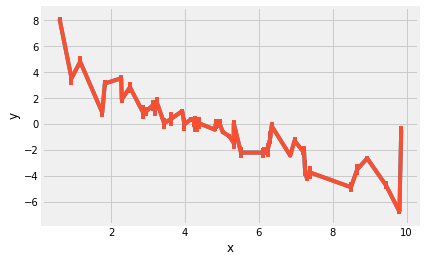

In [4]:
plt.plot(x, y)
plt.errorbar(x, y,yerr = yerror, markersize = 0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.grid('True')

In [5]:
def function(x0, a0, b0):
    return a0*x0 + b0

def likelihood(a, b, data):
    equis = data[0]
    ye = data[1]
    yerr = data[2] 
    model = function(equis, a, b)
    likelihood_0 = (ye-model)**2/(yerr**2)
    return likelihood_0.sum()

In [6]:
rango = 3000

a0 = -3
b0 = 4
lnlike0 = -1*likelihood(a0, b0, [x,y,yerror])

a_sample = [a0]
b_sample = [b0]

sigma = 0.01

for j in range(1,rango):
    a_new = np.random.normal(a_sample[len(a_sample)-1], sigma)
    b_new = np.random.normal(b_sample[len(a_sample)-1], sigma)
    like = -1*likelihood(a_new, b_new, [x,y,yerror])
    if like>lnlike0:
        lnlike0 = like
        a_sample.append(a_new)
        b_sample.append(b_new)
    elif lnlike0-like<-math.log(random.uniform(0,1)):
        lnlike0 = like
        a_sample.append(a_new)
        b_sample.append(b_new)

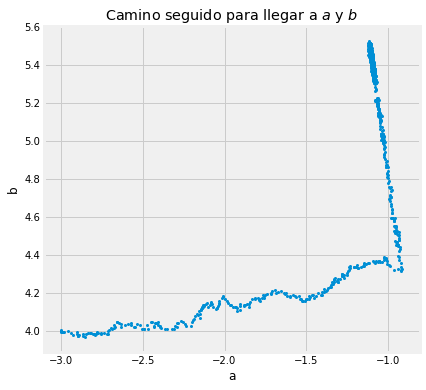

In [7]:
plt.figure(figsize = (6,6))
plt.plot(a_sample,b_sample, 'o', markersize = 2)
plt.xlabel('a')
plt.ylabel('b')
plt.title('Camino seguido para llegar a $a$ y $b$')
plt.grid('True')

In [8]:
len(a_sample)

1401

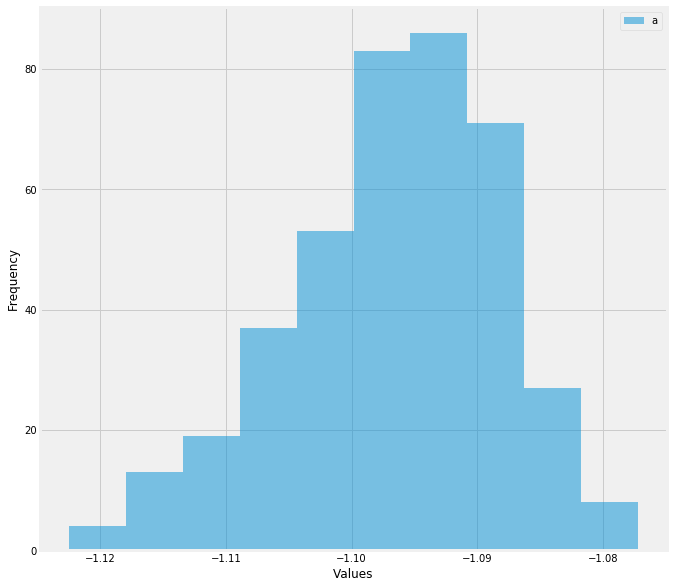

In [9]:
plt.figure(figsize = (10,10))
plt.hist(a_sample[1000: 2000], label = 'a',alpha=0.5);
plt.grid('True')
plt.xlabel('Values')
plt.legend()
plt.ylabel('Frequency');

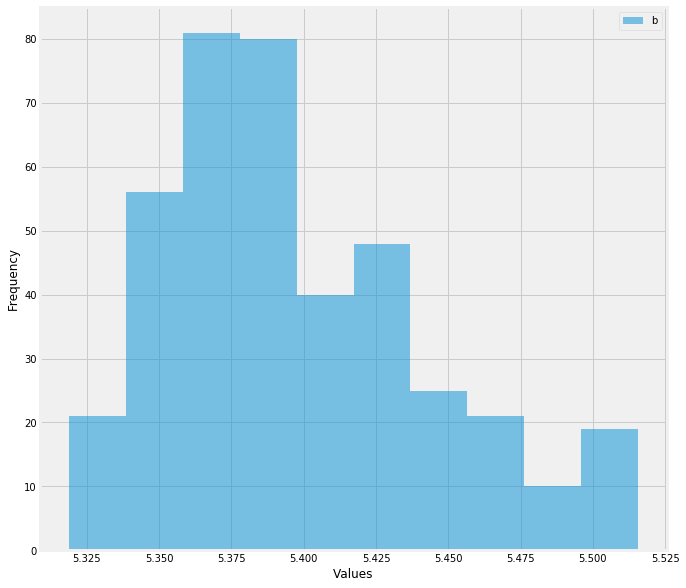

In [10]:
plt.figure(figsize = (10,10))
plt.hist(b_sample[1000: 2000], label = 'b',alpha=0.5);
plt.grid('True')
plt.xlabel('Values')
plt.legend()
plt.ylabel('Frequency');

2.-Grafica tu modelo contra los datos. ¿Qué tan bueno es el ajuste? ¿Cualitativamente? ¿Cuantitativamente?

Calculamos la mediana.

In [11]:
a_great = np.median(np.array(a_sample))
a_great

-1.0992158237727723

In [12]:
b_great = np.median(np.array(b_sample))
b_great

5.373994145855323

In [13]:
x_new = np.linspace(0,10,100)
y_new = a_great*x_new + b_great

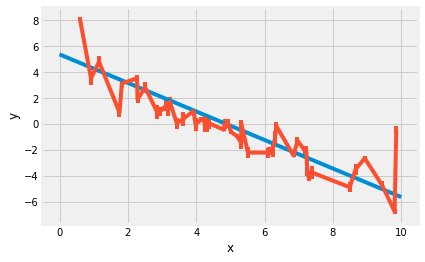

In [14]:
plt.plot(x_new, y_new)
plt.errorbar(x, y,yerr = yerror, markersize = 0.5)
plt.xlabel('x')
plt.ylabel('y')
plt.grid('True')

**Cualitativamente**: Se observa que se ajusta a los datos, ya que la pendiente y la ordenada hacen que la recta esté entre los datos. 

**Cuantitativamente**: ¿Cómo podemos expresar qué tan bien se ajustan nuestros datos a la recta?


Varios caminos:

In [15]:
a_total = []
b_total = []

sigma = 0.01
rango = 2500

for k in range(10):   
    a0 = np.random.normal(-2, 2, 10)
    b0 = np.random.normal(4, 2, 10)
    a_sample = [a0[k]]
    b_sample = [b0[k]]
    lnlike0 = -1*likelihood(a0[k], b0[k], [x,y,yerror])
    for j in range(1,rango):
        a_new = np.random.normal(a_sample[len(a_sample)-1], sigma)
        b_new = np.random.normal(b_sample[len(b_sample)-1], sigma)
        like = -1*likelihood(a_new, b_new, [x,y,yerror])
        if like>lnlike0:
            lnlike0 = like
            a_sample.append(a_new)
            b_sample.append(b_new)
        elif lnlike0-like<-math.log(random.uniform(0,1)):
            lnlike0 = like
            a_sample.append(a_new)
            b_sample.append(b_new)
    a_total.append(a_sample)
    b_total.append(b_sample)

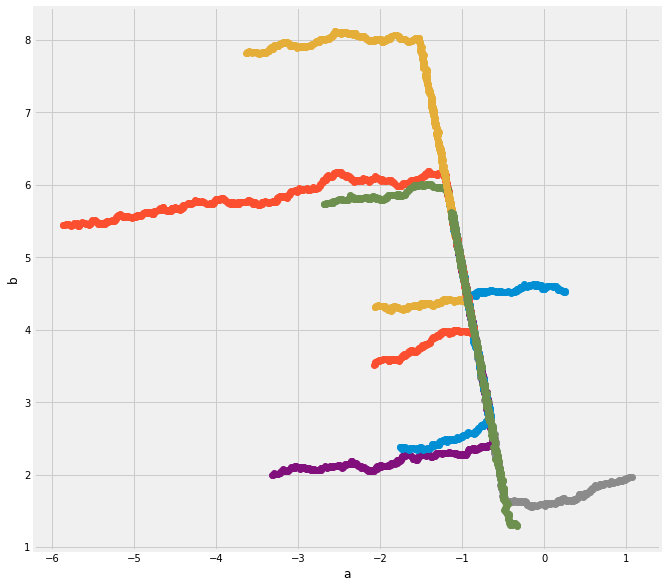

In [16]:
plt.figure(figsize = (10,10))
for i in range(10):
    plt.plot(a_total[i], b_total[i], 'o');
plt.grid('True')
plt.xlabel('a')
plt.ylabel('b');

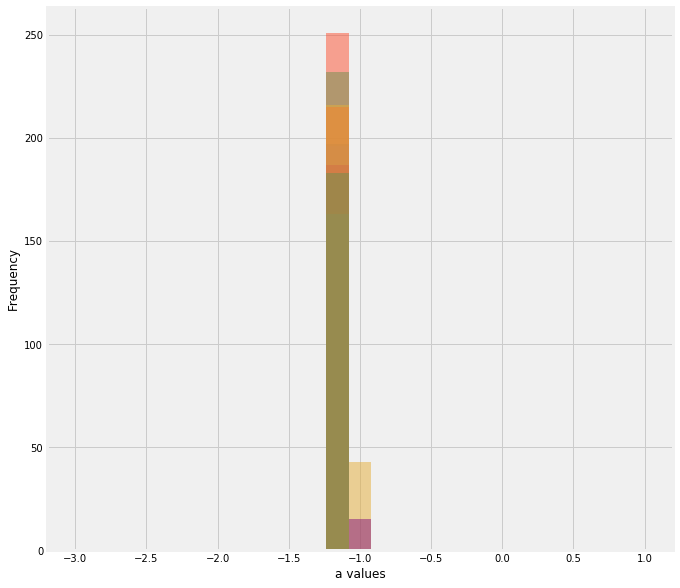

In [17]:
plt.figure(figsize = (10,10))
for i in range(10):
    plt.hist(a_total[i][950:2500], 25, range = (-3,1), alpha=0.5);

plt.grid('True')
plt.xlabel('a values')
plt.ylabel('Frequency');

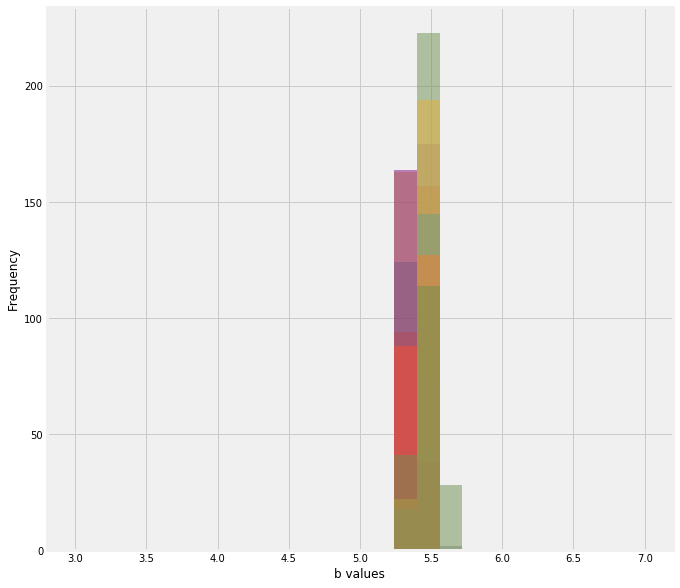

In [18]:
plt.figure(figsize = (10,10))
for i in range(10):
    plt.hist(b_total[i][950:2500], 25, range = (3,7), alpha=0.5);

plt.grid('True')
plt.xlabel('b values')
plt.ylabel('Frequency');

In [19]:
suma = 0
sumb = 0
for i in range(10):
    suma = suma + np.median(a_total[i])
    sumb = sumb + np.median(b_total[i])

In [20]:
suma/10

-1.0833895576774328

In [21]:
sumb/10

5.13578085550346

3.- Usa el método de Gelman-Rubin para determinar si tus cadenas han convergido.Referencia: https://arxiv.org/pdf/1812.09384.pdf 


In [22]:
n = 10
m = 500

def prom_x_i(x_it):
    return np.mean(x_it)

def prom_mu(x_i):
    sum = 0
    for i in range(n):
        sum = sum + prom_x_i(x_i[i])
    return sum/n

def s_i2(x_it):
    return np.std(x_it)

def s2(x_i):
    sum = 0
    for i in range(n):
        sum = sum + s_i2(x_i[i])
    return sum/n

def B_n(x_i):
    sum = 0
    for i in range(n):
        sum = sum + (prom_x_i(x_i[i])-prom_mu(x_i))**2
    return sum/(n-1)

def sigma_gorro2(x_i, m):
    return (m-1)*s2(x_i)/m + B_n(x_i)

def R(x_i, m):
    return math.sqrt(sigma_gorro2(x_i, m)/s2(x_i))

In [23]:
R(a_total, len(a_total[0]))

1.1967929984352477

In [24]:
R(b_total, len(b_total[0]))

1.3714330390265765

**Nota:** Podríamos concluir que el parámetro $a$ es aceptable debido a Ra. Pero Rb no es tan bueno.

Cambiamos un poco nuestros códigos para mejorar Ra y Rb.

In [25]:
a_total = []
b_total = []

sigma = 0.01
rango = 2500

a0 = np.random.normal(-0.8, 1, 10)
b0 = np.random.normal(4, 0.5, 10)
for k in range(10):   
    a_sample = [a0[k]]
    b_sample = [b0[k]]
    lnlike0 = -1*likelihood(a0[k], b0[k], [x,y,yerror])
    for j in range(1,rango):
        a_new = np.random.normal(a_sample[len(a_sample)-1], sigma)
        b_new = np.random.normal(b_sample[len(b_sample)-1], sigma)
        like = -1*likelihood(a_new, b_new, [x,y,yerror])
        if like>lnlike0:
            lnlike0 = like
            a_sample.append(a_new)
            b_sample.append(b_new)
        elif lnlike0-like<-math.log(random.uniform(0,1)):
            lnlike0 = like
            a_sample.append(a_new)
            b_sample.append(b_new)
    a_total.append(a_sample)
    b_total.append(b_sample)

In [26]:
R(a_total, len(a_total[0]))

1.0174284332910983

In [27]:
R(b_total, len(b_total[0]))

1.0214127052829831

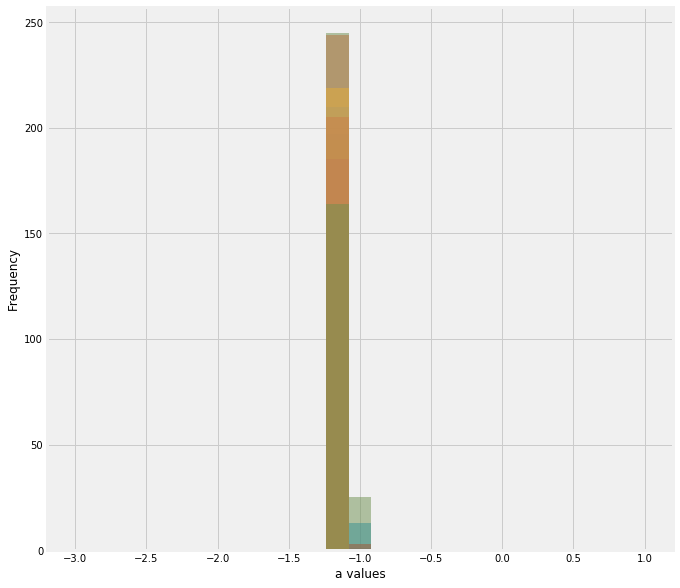

In [28]:
plt.figure(figsize = (10,10))
for i in range(10):
    plt.hist(a_total[i][950:2500], 25, range = (-3,1), alpha=0.5);

plt.grid('True')
plt.xlabel('a values')
plt.ylabel('Frequency');

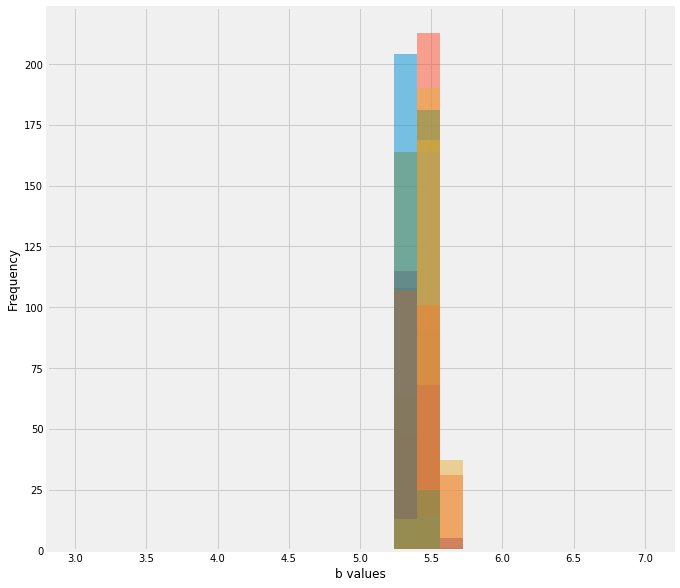

In [29]:
plt.figure(figsize = (10,10))
for i in range(10):
    plt.hist(b_total[i][950:2500], 25, range = (3,7), alpha=0.5);

plt.grid('True')
plt.xlabel('b values')
plt.ylabel('Frequency');

Quitamos el burning:

In [30]:
for i in range(10):
    a_total[i] = a_total[i][1000:2000]
    b_total[i] = b_total[i][1000:2000]

In [31]:
R(a_total, len(a_total[0]))

1.0033051483394808

In [32]:
R(b_total, len(b_total[0]))

1.050425647039965

## **Agregamos un nuevo parámetro: parámetro de errores**

- Con un camino:

In [33]:
def function(x0, a0, b0):
    return a0*x0 + b0

def likelihood(a, b, f,data):
    equis = data[0]
    ye = data[1]
    yerr = data[2] 
    model = function(equis, a, b)
    likelihood_0 = (ye-model)**2/(yerr**2 + (f**2)*model**2)
    return likelihood_0.sum()

In [62]:
rango = 3000

a0 = -1
b0 = 4.0
f0 = 0.3
lnlike0 = -1*likelihood(a0, b0, f0,[x,y,yerror])

a_sample = [a0]
b_sample = [b0]
f_sample = [f0]

sigma = 0.01

for j in range(1,rango):
    a_new = np.random.normal(a_sample[len(a_sample)-1], sigma)
    b_new = np.random.normal(b_sample[len(b_sample)-1], sigma)
    f_new = np.random.normal(f_sample[len(f_sample)-1], sigma)
    like = -1*likelihood(a_new, b_new, f_new, [x,y,yerror])
    if a_new <= -0.45 and a_new >= -1.45 and b_new <= 4.5 and b_new >= 3.5 and f_new <= 1 and f_new >= 0.2:
        if like>lnlike0:
            lnlike0 = like
            a_sample.append(a_new)
            b_sample.append(b_new)
            f_sample.append(f_new)
        elif lnlike0-like<-math.log(random.uniform(0,1)):
            lnlike0 = like
            a_sample.append(a_new)
            b_sample.append(b_new)
            f_sample.append(f_new)

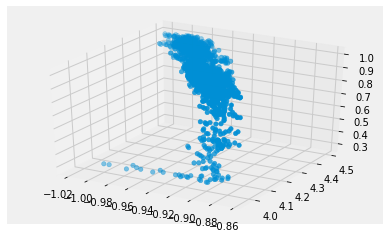

In [35]:
from mpl_toolkits.mplot3d import axes3d

fig = plt.figure()
ax1 = fig.add_subplot(111,projection='3d')

ax1.scatter(a_sample, b_sample, f_sample)


(array([  4.,   5.,   9.,   5.,  13.,  37.,  62.,  83., 145., 137.]),
 array([0.86493081, 0.87843322, 0.89193563, 0.90543804, 0.91894044,
        0.93244285, 0.94594526, 0.95944767, 0.97295008, 0.98645249,
        0.9999549 ]),
 <a list of 10 Patch objects>)

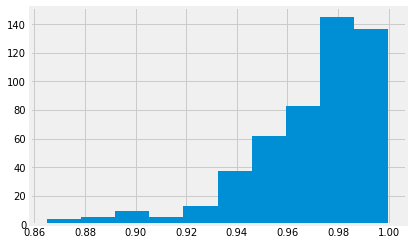

In [36]:
plt.hist(f_sample[1000:1500])

(array([ 40., 166., 269., 176., 148., 268., 303., 291., 167.,  38.]),
 array([-1.01825639, -1.00280712, -0.98735786, -0.9719086 , -0.95645934,
        -0.94101008, -0.92556081, -0.91011155, -0.89466229, -0.87921303,
        -0.86376377]),
 <a list of 10 Patch objects>)

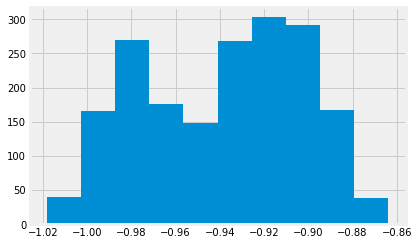

In [37]:
plt.hist(a_sample)

(array([136., 213., 232., 235., 280.,  82., 100., 138., 220., 230.]),
 array([3.93983566, 3.99584719, 4.05185872, 4.10787025, 4.16388178,
        4.21989331, 4.27590484, 4.33191637, 4.38792791, 4.44393944,
        4.49995097]),
 <a list of 10 Patch objects>)

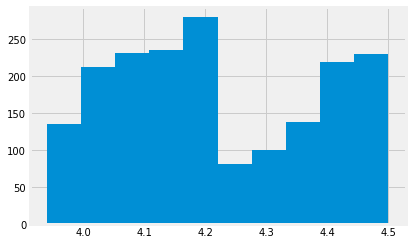

In [38]:
plt.hist(b_sample)

- Con varios caminos

In [39]:
a_total = []
b_total = []
f_total = []

sigma = 0.05
rango = 20000

for k in range(10):   
    a0 = np.random.normal(-0.5, 0.5, 10)
    b0 = np.random.normal(4, 0.5, 10)
    f0 = np.random.normal(0.3, 0.5, 10)
    a_sample = [a0[k]]
    b_sample = [b0[k]]
    f_sample = [f0[k]]
    lnlike0 = -1*likelihood(a0[k], b0[k], f0[k],[x,y,yerror])
    for j in range(1,rango):
        a_new = np.random.normal(a_sample[len(a_sample)-1], sigma)
        b_new = np.random.normal(b_sample[len(b_sample)-1], sigma)
        f_new = np.random.normal(f_sample[len(f_sample)-1], sigma)
        like = -1*likelihood(a_new, b_new, f_new, [x,y,yerror])
        if a_new <= -0.45 and a_new >= -1.45 and b_new <= 4.5 and b_new >= 3.5 and f_new <= 1 and f_new >= 0.0:
            if like>lnlike0:
                lnlike0 = like
                a_sample.append(a_new)
                b_sample.append(b_new)
                f_sample.append(f_new)
            elif lnlike0-like<-math.log(random.uniform(0,1)):
                lnlike0 = like
                a_sample.append(a_new)
                b_sample.append(b_new)
                f_sample.append(f_new)
    a_total.append(a_sample)
    b_total.append(b_sample)
    f_total.append(f_sample)

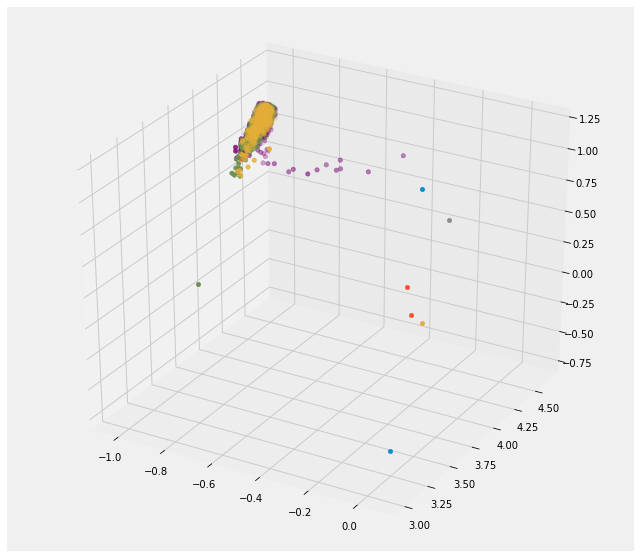

In [40]:
fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(111,projection='3d')

for i in range(10):
    ax1.scatter(a_total[i], b_total[i], f_total[i])

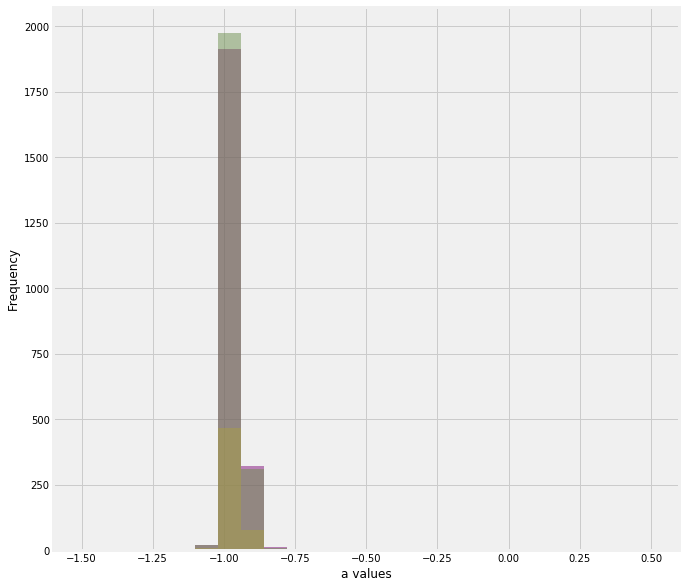

In [41]:
plt.figure(figsize = (10,10))
for i in range(10):
    plt.hist(a_total[i], 25, range = (-1.5, 0.5), alpha=0.5);

plt.grid('True')
plt.xlabel('a values')
plt.ylabel('Frequency');

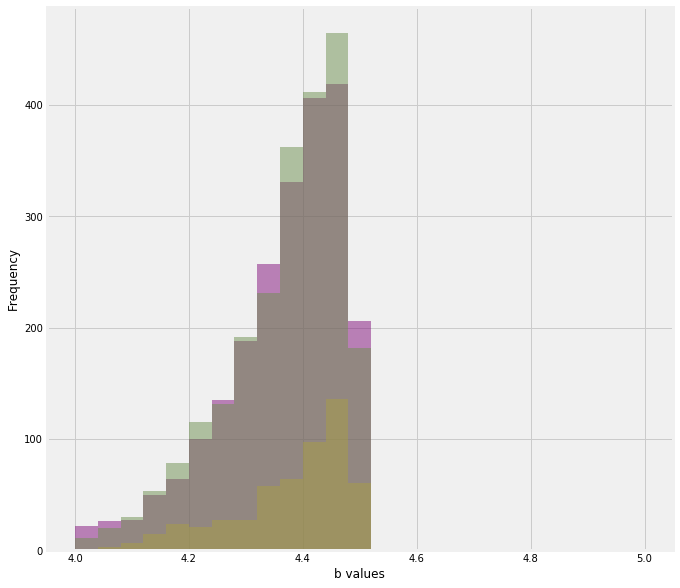

In [42]:
plt.figure(figsize = (10,10))
for i in range(10):
    plt.hist(b_total[i], 25, range = (4.0,5.0), alpha=0.5);

plt.grid('True')
plt.xlabel('b values')
plt.ylabel('Frequency');

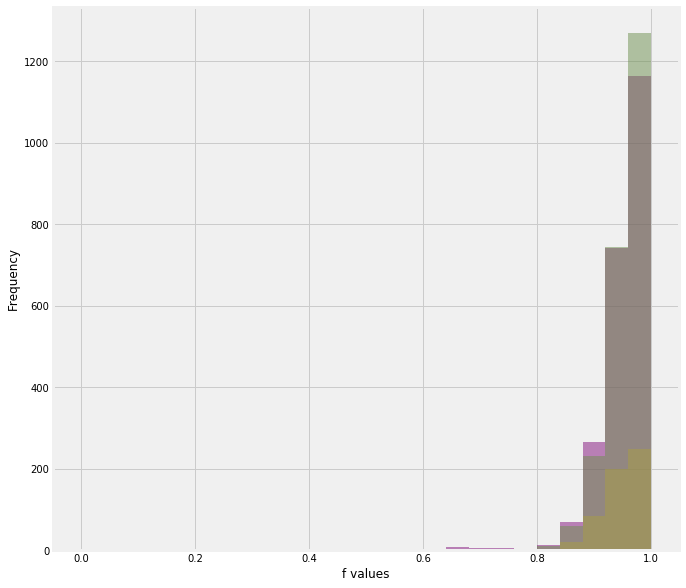

In [43]:
plt.figure(figsize = (10,10))
for i in range(10):
    plt.hist(f_total[i], 25, range = (0.0,1.0), alpha=0.5);

plt.grid('True')
plt.xlabel('f values')
plt.ylabel('Frequency');

Quitamos el burning:

In [44]:
a_new = []
b_new = []
f_new = []

for i in range(10):
    if len(a_total[i])>=1000 and len(b_total[i])>=1000 and len(f_total[i])>=1000:
        a_new.append(a_total[i][1000:2000])
        b_new.append(b_total[i][1000:2000])
        f_new.append(f_total[i][1000:2000])

In [45]:
len(a_new)

2

In [46]:
n = len(a_new)
R(a_new,len(a_new[0]))

0.9995073832137893

In [47]:
R(b_new, len(b_new[0]))

0.9995040847772412

In [48]:
R(f_new, len(f_new[0]))

0.9995051078091355

Notamos que sin el burning, los valores de R para cada parámetro son muy cercanos a uno.

- Calculamos medianas.

In [49]:
pendiente = np.median(a_new)

In [50]:
ordenada = np.median(b_new)

In [51]:
error = np.median(f_new)

In [52]:
np.mean(a_new)

-0.9685043012905041

In [53]:
np.mean(b_new)

4.352968024927523

In [54]:
np.mean(f_new)

0.95705026216497

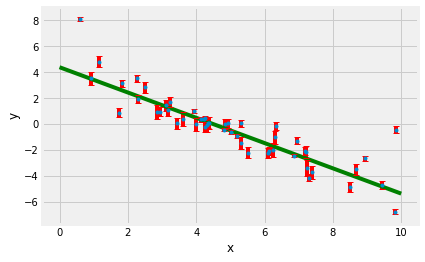

In [55]:
x_new = np.linspace(0,10,100)
y_new = x_new*pendiente + ordenada

plt.plot(x_new, y_new, '-g')
plt.errorbar(x, y,yerr = yerror, fmt = 'o', markersize = 3, ecolor = 'red', capsize = 3)
plt.xlabel('x')
plt.ylabel('y')
plt.grid('True')

Observamos la dispersión:

Text(0.5, 0, 'b')

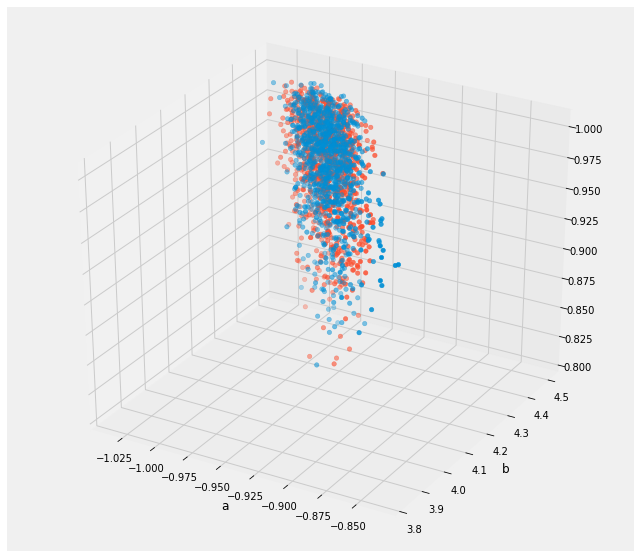

In [56]:
fig = plt.figure(figsize = (10,10))
ax1 = fig.add_subplot(111,projection='3d')

for i in range(len(a_new)):
    ax1.scatter(a_new[i], b_new[i], f_new[i])
    
plt.xlabel('a')
plt.ylabel('b')

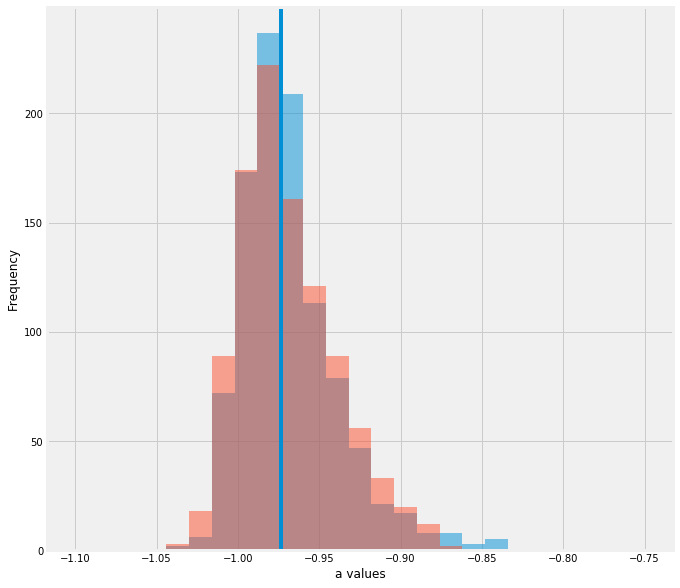

In [57]:
plt.figure(figsize = (10,10))
for i in range(len(a_new)):
    plt.hist(a_new[i], 25, range = (-1.1, -0.75), alpha=0.5);

plt.grid('True')
plt.axvline(pendiente)
plt.xlabel('a values')
plt.ylabel('Frequency');

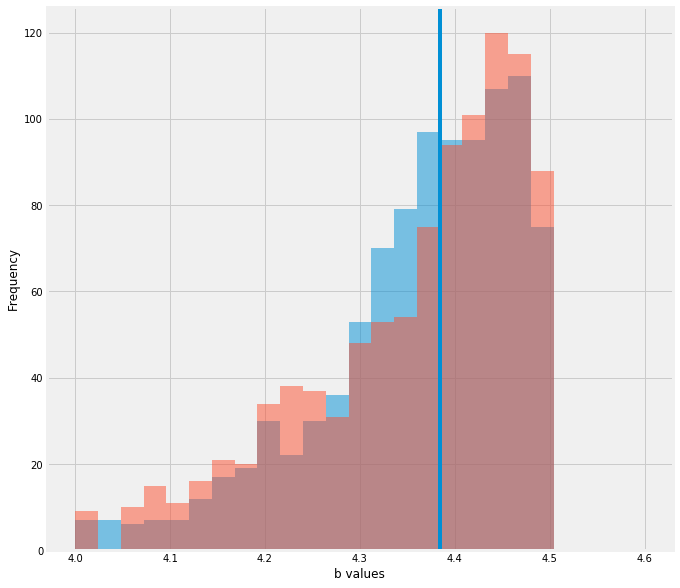

In [58]:
plt.figure(figsize = (10,10))
for i in range(len(a_new)):
    plt.hist(b_new[i], 25, range = (4, 4.6), alpha=0.5);

plt.grid('True')
plt.axvline(ordenada)
plt.xlabel('b values')
plt.ylabel('Frequency');

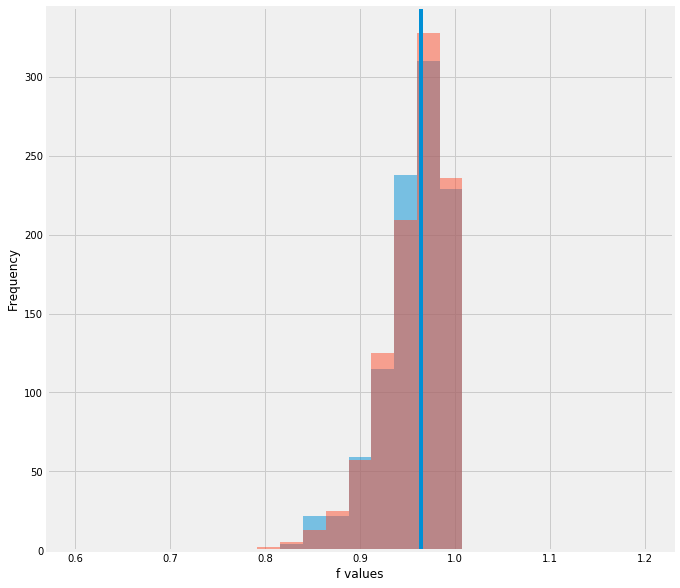

In [59]:
plt.figure(figsize = (10,10))
for i in range(len(a_new)):
    plt.hist(f_new[i], 25, range = (0.6, 1.2), alpha=0.5);

plt.grid('True')
plt.axvline(error)
plt.xlabel('f values')
plt.ylabel('Frequency');